In [1]:
#python notebook file which will contain the asset return predictions

### 1. Importing Modules

In [2]:
import random
import os
import math

import pandas as pd
import numpy as np
from numpy.random import seed 
import tensorflow as tf

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from pmdarima.arima import auto_arima

from keras_tuner import BayesianOptimization
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras import optimizers 
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers.legacy import Adam


/var/folders/d3/5_l3h7cd1c98_xcdw8_wgkbh0000gn/T/ipykernel_83432/2725660472.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
#setting seed for reproducability
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
#general hyperparameter for lstm
input_steps = 20
output_steps = 1 #one day ahead prediction

### 2. Defining Functions

In [5]:
#function - creating two sequence out of which one predicts the other (from: https://github.com/krishnaik06/Time-Series-Forecasting/blob/master/UnivariateTimeSeries.ipynb)
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

### 3. Loading Data

In [6]:
# Initialize an empty dictionary to store the loaded DataFrames
data_dict = {}

# Define the directory where the CSV files are saved
directory = '/Users/cemakkus/PycharmProjects/Master/data/'

# Iterate through each file in the directory
for filename in os.listdir(directory):
    if filename.startswith('export_') and filename.endswith('.csv'):
        # Extract the ticker from the filename
        ticker = filename.replace('export_', '').replace('.csv', '')
        
        # Define the full file path
        file_path = os.path.join(directory, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        data_dict[ticker] = df.iloc[output_steps:]  # Select all rows except the last rows that contain nan's
        
        
        print(f'DataFrame for {ticker} loaded from {file_path}')


# At this point, data_dict contains all DataFrames, keyed and sorted by ticker
data_dict = {k: data_dict[k] for k in sorted(data_dict)}


DataFrame for SAF_PA loaded from /Users/cemakkus/PycharmProjects/Master/data/export_SAF_PA.csv
DataFrame for MUV2_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/export_MUV2_DE.csv
DataFrame for ISP_MI loaded from /Users/cemakkus/PycharmProjects/Master/data/export_ISP_MI.csv
DataFrame for ASML_AS loaded from /Users/cemakkus/PycharmProjects/Master/data/export_ASML_AS.csv
DataFrame for BN_PA loaded from /Users/cemakkus/PycharmProjects/Master/data/export_BN_PA.csv
DataFrame for BBVA_MC loaded from /Users/cemakkus/PycharmProjects/Master/data/export_BBVA_MC.csv
DataFrame for CRH loaded from /Users/cemakkus/PycharmProjects/Master/data/export_CRH.csv
DataFrame for ITX_MC loaded from /Users/cemakkus/PycharmProjects/Master/data/export_ITX_MC.csv
DataFrame for BAYN_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/export_BAYN_DE.csv
DataFrame for DB1_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/export_DB1_DE.csv
DataFrame for ADS_DE loaded from /Users/cemakkus/P

### 4. Feature Engineering for LSTM

In [7]:
#hyperparameter for feature engineering (at this part of the code, so models use exactly the same dates for their predictions)
n_features = 2
window = 10

In [8]:
#feature engineering for other top 3 german components in eurostoxx50 prediction
rolmean_SAP = data_dict['SAP_DE']['1d_return'].rolling(window).mean()
rolstd_SAP = data_dict['SAP_DE']['1d_return'].rolling(window).std()

rolmean_SIE = data_dict['SIE_DE']['1d_return'].rolling(window).mean()
rolstd_SIE = data_dict['SIE_DE']['1d_return'].rolling(window).std()

rolmean_DTE = data_dict['DTE_DE']['1d_return'].rolling(window).mean()
rolstd_DTE = data_dict['DTE_DE']['1d_return'].rolling(window).std()

#adding features as columns in dataframe for dax
data_dict['SAP_DE']['Rolling_Mean'] = rolmean_SAP
data_dict['SAP_DE']['Rolling_Std'] = rolstd_SAP

data_dict['SIE_DE']['Rolling_Mean'] = rolmean_SIE
data_dict['SIE_DE']['Rolling_Std'] = rolstd_SIE

#adding features as columns in dataframe for dax
data_dict['DTE_DE']['Rolling_Mean'] = rolmean_DTE
data_dict['DTE_DE']['Rolling_Std'] = rolstd_DTE

In [9]:
#disregarding rows for which feature values can not be generated - top 3 german components
data_dict['SAP_DE'] = data_dict['SAP_DE'][window-1:]

data_dict['SIE_DE'] = data_dict['SIE_DE'][window-1:]

data_dict['DTE_DE'] = data_dict['DTE_DE'][window-1:]

#do this for all if needed later

### 5. Pre-Processing for ARIMA (Determining Best ARIMA models & Generating Train/Test Sets)

In [10]:
#hyperparameter for train/test split
train_test_ratio = 0.8

In [11]:
#split sap asset returns into train and test set
train_arima_SAP, test_arima_SAP = train_test_split(data_dict['SAP_DE']['1d_return'], test_size=1-train_test_ratio, shuffle = False)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-4161.643, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-4162.940, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-4162.455, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-4165.928, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-4164.305, Time=0.06 sec


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-4164.799, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4163.077, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-4162.347, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-4163.945, Time=0.08 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 0.714 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  814
Model:               SARIMAX(2, 0, 0)   Log Likelihood                2085.964
Date:                Thu, 22 Feb 2024   AIC                          -4165.928
Time:                        14:50:12   BIC                          -4151.822
Sample:                             0   HQIC                         -4160.513
                                - 814                                         
Covariance Type:                  opg                                         
                 coef  

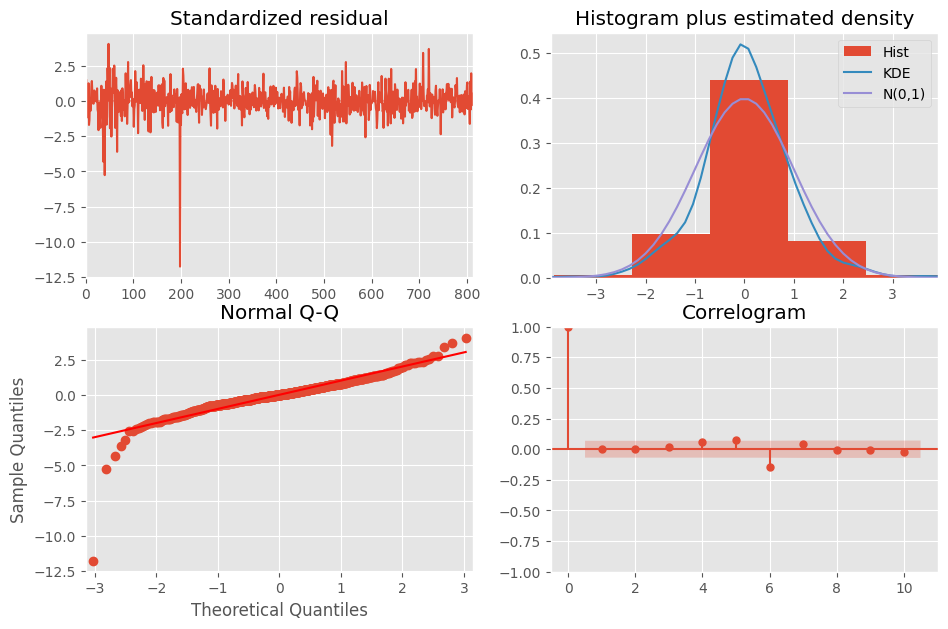

In [12]:
#determining most suitable arima order for dax prediction
autoarima_SAP = auto_arima(train_arima_SAP, 
                      start_p=0, start_q=0,  #minimum p and q
                      test='adf',            #use augmented dickey-fuller test to find optimal 'd'
                      max_p=3, max_q=3,      #maximum p and q
                      d=None,                #let model determine 'd'
                      seasonal=False,        #no seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(autoarima_SAP.summary())
autoarima_SAP.plot_diagnostics(figsize=(11,7))
plt.show()

### 6. Pre-Processing for LSTM (Splitting Sequences & Generating Train/Test Sets)

In [13]:
#general hyperparameter
input_steps = 20
output_steps = 1 #one day ahead prediction

In [14]:
#creating two sequence out of which one predicts the other - asset return of dax
X_SAP,Y_SAP = split_sequence(data_dict['SAP_DE']['1d_return'], input_steps, output_steps)

#creating two sequence out of which one predicts the other - features of SAP
X1_SAP,Y1_SAP = split_sequence(data_dict['SAP_DE']['Rolling_Mean'], input_steps, output_steps)

X2_SAP,Y2_SAP = split_sequence(data_dict['SAP_DE']['Rolling_Std'], input_steps, output_steps)

#concatenating input variables for lstm
X_ft_SAP = np.concatenate([X_SAP,X1_SAP,X2_SAP])

#reshaping
#X_SAP = np.reshape(X_SAP, (X_SAP.shape[0], input_steps, 1), order='F')
X_ft_SAP = np.reshape(X_ft_SAP, (int(X_ft_SAP.shape[0]/(n_features+1)), input_steps, n_features + 1), order='F')
Y_SAP = np.reshape(Y_SAP, (Y_SAP.shape[0], output_steps), order='F')

#bringing Y in array form
Y_SAP = [i[output_steps - 1] for i in Y_SAP.tolist()]
Y_SAP = np.array(Y_SAP)

# #splitting sequence into train and test data
# X_ft_train_SAP, X_ft_test_SAP, Y_train_SAP, Y_test_SAP = train_test_split(X_ft_SAP, Y_SAP, test_size=1-train_test_ratio, shuffle = False) #with features

#splitting sequence into train, val and test data (60-20-20 split)
# First split: Separate out the test set
X_temp, X_ft_test_SAP, Y_temp, Y_test_SAP = train_test_split(X_ft_SAP, Y_SAP, test_size=1-train_test_ratio, shuffle=False)
# Second split: Split the remaining data into training and validation sets
X_ft_train_SAP, X_ft_val_SAP, Y_train_SAP, Y_val_SAP = train_test_split(X_temp, Y_temp, test_size=0.25, shuffle=False)  # 0.25 * 0.8 = 0.2 # 0.1765 * 0.85 = 0.15

## 2. One day ahead prediction

### 2.1 LSTM Model & Prediction

In [15]:
#hyperparameter for lstm
epochs = 50
verbose = 1

In [35]:
#need to set seeds again in this part of the code for lstm to get the same outputs
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
#LSTM model for dax asset return prediction
model_LSTM = tf.keras.Sequential()
model_LSTM.add(tf.keras.layers.LSTM(20, activation='sigmoid', return_sequences=False, input_shape=(input_steps, n_features + 1)))
model_LSTM.add(tf.keras.layers.Dense(1))
model_LSTM.compile(optimizer='Adam', loss='mse')

#training model 
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
# history_LSTM_SAP = model_LSTM.fit(X_ft_train_SAP, Y_train_SAP, validation_split=0.3, callbacks=[early_stopping], epochs = epochs, verbose = verbose)
history_LSTM_SAP = model_LSTM.fit(X_ft_train_SAP, Y_train_SAP, epochs = epochs, verbose = verbose, validation_data=(X_ft_val_SAP, Y_val_SAP))

#predicting values for SAP asset returns
yhat_SAP=model_LSTM.predict(X_ft_test_SAP)

Epoch 1/50
16/16 [==============================] - 1s 9ms/step - loss: 0.0169 - val_loss: 0.0015
Epoch 2/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 5.1380e-04
Epoch 3/50
16/16 [==============================] - 0s 3ms/step - loss: 6.0020e-04 - val_loss: 4.5629e-04
Epoch 4/50
16/16 [==============================] - 0s 3ms/step - loss: 4.4926e-04 - val_loss: 3.6097e-04
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 4.3590e-04 - val_loss: 2.9011e-04
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 4.1032e-04 - val_loss: 2.9310e-04
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 4.1337e-04 - val_loss: 2.8800e-04
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 4.0883e-04 - val_loss: 2.9143e-04
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 4.1049e-04 - val_loss: 2.8785e-04
Epoch 10/50
16/16 [==============================] - 0s 3m

In [ ]:
#hpo

In [29]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=8, max_value=64, step=8),
        #activation = hp.Choice("activation", values = ["sigmoid", "tanh", "relu"]),
        return_sequences=False,
        input_shape=(input_steps, n_features + 1)))
    model.add(Dense(1))
    
    # Setting learning rate within the optimizer configuration
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    #optimizer = optimizers.Adam(learning_rate=learning_rate)
    optimizer = Adam(learning_rate=learning_rate) #legacy Adam
    
    model.compile(optimizer=optimizer, loss='mse')
    return model

In [30]:
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=20,  # Number of trials to run
    executions_per_trial=1,  # Number of models that should be built and fit for each trial
    directory='directory',  # Directory to save logs and models
    project_name='project',
    overwrite = True
)

In [31]:
tuner.search(X_ft_train_SAP, Y_train_SAP,
             epochs=50,
             validation_data=(X_ft_val_SAP, Y_val_SAP),
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

Trial 20 Complete [00h 00m 02s]
val_loss: 0.0002470744657330215

Best val_loss So Far: 0.00024345405108761042
Total elapsed time: 00h 00m 38s


In [36]:
# best hyperparameters
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_hyperparameters = best_trial.hyperparameters.values

# print the best hyperparameters
print("Best Hyperparameters:")
for key, value in best_hyperparameters.items():
    print(f"{key}: {value}")

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]


Best Hyperparameters:
units: 64
learning_rate: 0.00038086910070967133


In [38]:
history_LSTM_SAP = best_model.fit(X_ft_train_SAP, Y_train_SAP, epochs=epochs, verbose=verbose, validation_data=(X_ft_val_SAP, Y_val_SAP))

# Predicting values for SAP asset returns
yhat_SAP = best_model.predict(X_ft_test_SAP)

Epoch 1/50
19/19 [==============================] - 0s 5ms/step - loss: 3.7146e-04 - val_loss: 2.5374e-04
Epoch 2/50
19/19 [==============================] - 0s 4ms/step - loss: 3.7076e-04 - val_loss: 2.5009e-04
Epoch 3/50
19/19 [==============================] - 0s 4ms/step - loss: 3.8128e-04 - val_loss: 2.4954e-04
Epoch 4/50
19/19 [==============================] - 0s 4ms/step - loss: 3.7686e-04 - val_loss: 2.5147e-04
Epoch 5/50
19/19 [==============================] - 0s 4ms/step - loss: 3.7176e-04 - val_loss: 2.4995e-04
Epoch 6/50
19/19 [==============================] - 0s 4ms/step - loss: 3.7140e-04 - val_loss: 2.5036e-04
Epoch 7/50
19/19 [==============================] - 0s 4ms/step - loss: 3.7256e-04 - val_loss: 2.5738e-04
Epoch 8/50
19/19 [==============================] - 0s 4ms/step - loss: 3.7280e-04 - val_loss: 2.5284e-04
Epoch 9/50
19/19 [==============================] - 0s 4ms/step - loss: 3.7157e-04 - val_loss: 2.5384e-04
Epoch 10/50
19/19 [===========================

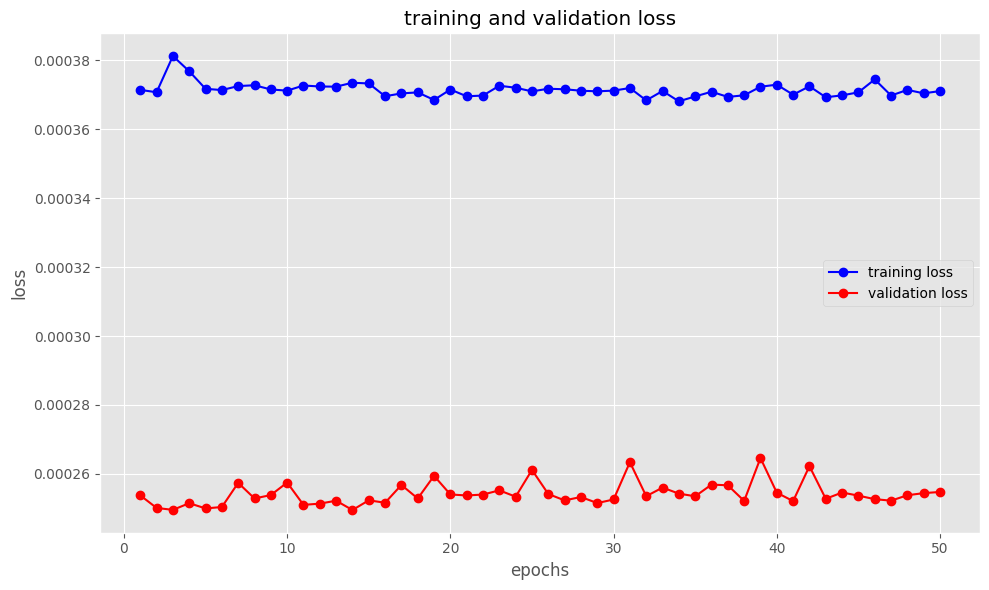

In [39]:
#plot - loss of lstm sap prediction
train_loss = history_LSTM_SAP.history['loss']
val_loss = history_LSTM_SAP.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='training loss')
plt.plot(epochs, val_loss, 'ro-', label='validation loss')
plt.title('training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.tight_layout()
